# An introduction to Convolutional Neural Networks using TensorFlow & Keras

To start, the necessary libraries are loaded.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.math import confusion_matrix

## 1. Data exploration

Unlike many introductions to machine learning, Fashion-MNIST is used in place of the classic MNIST. Data is already included in Tensorlow, therefore it is strightforward to collect it without loading any file.

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Train set contains 60000 images of size 28x28, while test set contains 10000 images of the same size. No validation set is provided.

As an example, the next chunk shows the representation of the first image in the train set.

In [ ]:
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

Since an image can be seen as a 28x28 grid of pixels, this array contains 28 elements (i.e. the rows of the grid), which are arrays containing 28 elements (i.e. the elements in that row, following the columns' order), whose values are the grayscale numerical representation for a pixel. These values varies from 0 (black) to 255 (white).

In [ ]:
print(y_train)

[9 0 0 ... 3 0 5]


The target variable contains integer values for both train and test sets, following this schema:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [ ]:
print(np.unique(y_train, return_counts=True)[1])
print(np.unique(y_test, return_counts=True)[1])

[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Classes are equally distributed, so it is not necessary to balance them.

A new variable with the ordered classes names is created.

In [ ]:
classes_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Let's take a look at some images.

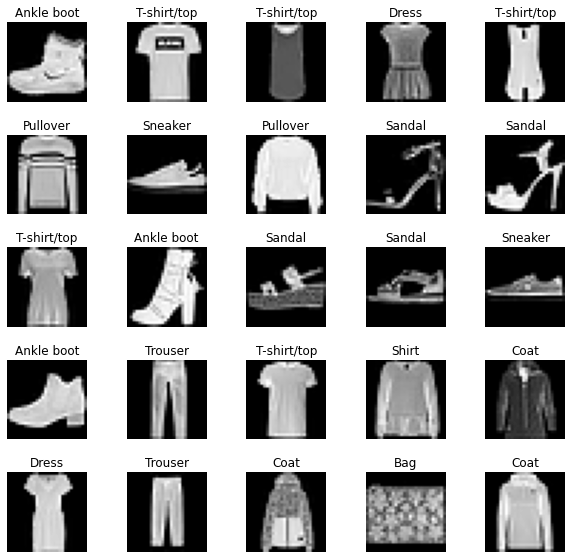

In [ ]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
axes = axes.ravel()

for i in range(0, 25):  
    axes[i].imshow(X_train[i].reshape(28, 28), cmap="gray")
    axes[i].set_title(classes_names[y_train[i]])
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)
plt.show()

## 2. Data pre-processing

Since no validation set is provided, this is created taking out a stratified sample of the images from the train set. The stratification is used to keep the classes balanced.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

As seen before, the grayscale numerical representation provided integer values spanning from 0 to 255. These values are divided by 255, so now they goes from 0 (black pixel) to 1 (white pixel).

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

A data reshaping is done to provide the inputs for the neural network.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## 3. Model

A Convolutional Neural Network is created to classify the images.

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(28, 28, 1))) 
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

Take a look at the model summary.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0

As loss function, sparse categorical crossentropy is used instead of the usual categorical crossentropy, since the target variable has integer values (instead of being one-hot encoded).

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Two callbacks are created and will be activated in case the model is not improving for a few epochs. One involves a reduction of the learning rate, the other one is a stopping rule that interrupts the model fitting in case the model is not improving for ten epochs.

In [ ]:
learning_control = ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1, factor=0.1, min_lr=0.000001)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto")

Considering the callbacks, a generous value is set for the epochs number.

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=64,
                    epochs=100,
                    callbacks=[learning_control, early_stopping])

Epoch 1/100
750/750 [==============================] - 5s 7ms/step - loss: 0.5449 - accuracy: 0.8004 - val_loss: 0.3523 - val_accuracy: 0.8657
Epoch 2/100
750/750 [==============================] - 5s 6ms/step - loss: 0.3737 - accuracy: 0.8615 - val_loss: 0.3068 - val_accuracy: 0.8864
Epoch 3/100
750/750 [==============================] - 5s 6ms/step - loss: 0.3294 - accuracy: 0.8762 - val_loss: 0.2746 - val_accuracy: 0.8996
Epoch 4/100
750/750 [==============================] - 5s 6ms/step - loss: 0.3035 - accuracy: 0.8849 - val_loss: 0.2522 - val_accuracy: 0.9057
Epoch 5/100
750/750 [==============================] - 5s 6ms/step - loss: 0.2877 - accuracy: 0.8925 - val_loss: 0.2454 - val_accuracy: 0.9062
Epoch 6/100
750/750 [==============================] - 5s 6ms/step - loss: 0.2753 - accuracy: 0.8974 - val_loss: 0.2645 - val_accuracy: 0.9009
Epoch 7/100
750/750 [==============================] - 5s 6ms/step - loss: 0.2643 - accuracy: 0.9010 - val_loss: 0.2627 - val_accuracy: 0.9058

## 4. Results

In [ ]:
print("Train set:")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print("\nValidation accuracy:")
valid_loss, valid_acc = model.evaluate(X_valid, y_valid, verbose=2)
print("\nTest accuracy:")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Train set:
1500/1500 - 3s - loss: 0.0723 - accuracy: 0.9741

Validation accuracy:
375/375 - 1s - loss: 0.1853 - accuracy: 0.9382

Test accuracy:
313/313 - 1s - loss: 0.2081 - accuracy: 0.9323


The accuracy on validation and test set is similar, on the other hand it is a bit higher for the train set, but this is reasonable since the model is build with that data. Overfitting is negligible, since the model performed well and similarly for all the three sets.

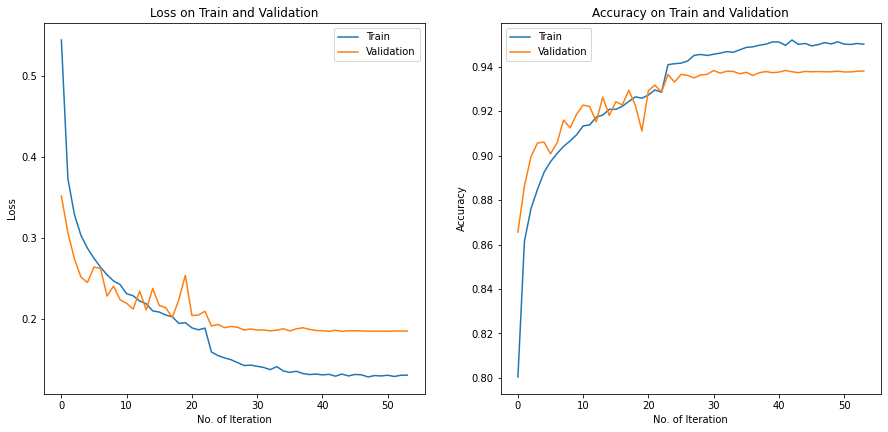

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss on Train and Validation")

plt.subplot(2, 2, 2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Train and Validation")

plt.show()

After around twenty epochs, loss function and accuracy stopped to improve significantly for the validation set.

Since the model provides the posterior probabilities for every image, the predicted class for that image will be the one with the larger posterior probability.

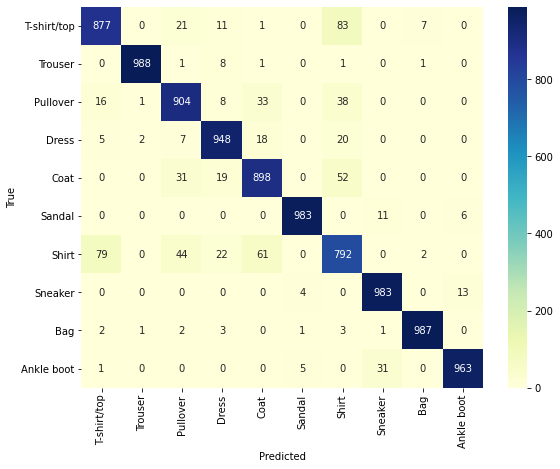

In [ ]:
predictions = model.predict(X_test)
pred_test = predictions.argmax(1)

cf_matrix = confusion_matrix(labels=y_test, predictions=pred_test)

fig, ax = plt.subplots(figsize=(9, 7))
heatmap(cf_matrix, annot=True, fmt="g", cmap="YlGnBu", xticklabels=classes_names, yticklabels=classes_names)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

The confusion matrix resembles a diagonal matrix and the misclassifications are usually reasonable (e.g. t-shirts or pullovers predicted as shirts).

In [ ]:
print("Classification report for CNN :\n%s\n"
      % (classification_report(y_true=y_test, y_pred=pred_test, target_names=classes_names)))

Classification report for CNN :
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.88      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.90      0.90      0.90      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.89      0.90      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.80      0.79      0.80      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




Precision and recall are larger than 0.9 for all classes, except "Shirt" and, to a lesser extent, "T-shirt/top", "Pullover" and "Coat". These classes are indeed full of pictures of clothes that could be easy to misclassify even for a human.

The following chunk exibit an example of true class versus the predicted one for 25 images.

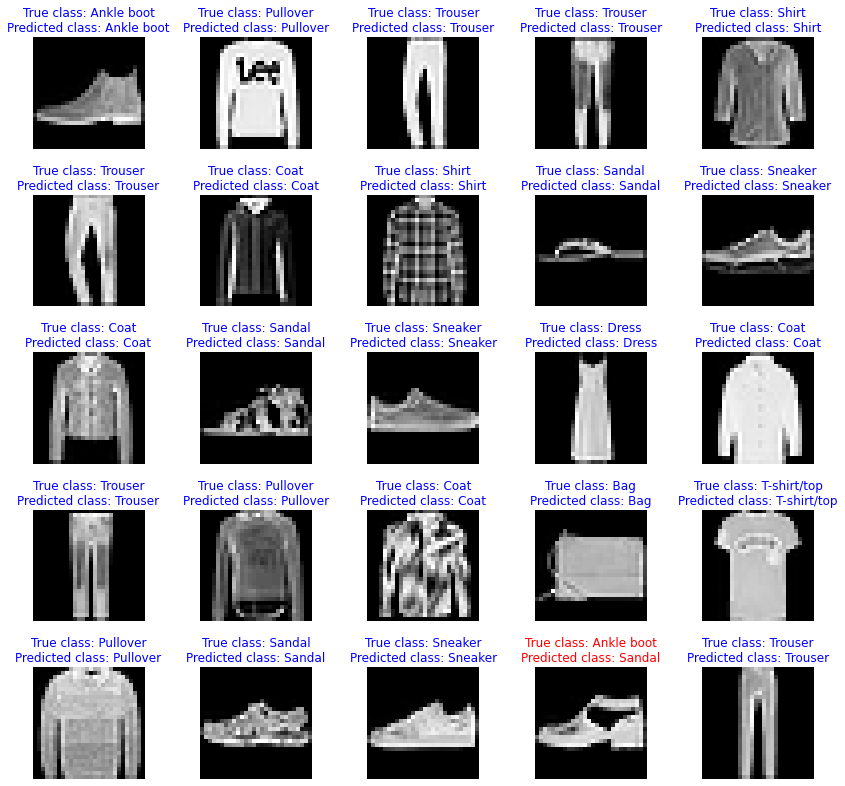

In [ ]:
fig, axes = plt.subplots(5, 5, figsize = (14, 14))
axes = axes.ravel()

for i in range(0, 25):  
    axes[i].imshow(X_test[i].reshape(28, 28), cmap = "gray")

    if y_test[i] == pred_test[i]:
      axes[i].set_title("True class: " + classes_names[y_test[i]] + "\nPredicted class: " + classes_names[pred_test[i]], color = "blue")
    else:
      axes[i].set_title("True class: " + classes_names[y_test[i]] + "\nPredicted class: " + classes_names[pred_test[i]], color = "red")

    axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)
plt.show()

From this sample, only one image is misclassified: despite being an ankle boot, the model predicts a sandal. This is a legit mistake, also justified by the fact that there is a black area at the center of the picture.

## 5. Final words

Despite its simplicity and no heavy pre-processing, the model provided a very good performance for this dataset. It is reasonable to think that the accuracy can be further improved by using a different and more complex architecture for the neural network, although the official benchmark shows a state of the art accuracy of 0.963 by using some standard preprocessing and image augmentation.